# 2 - Simulation - Maximum Possible Return on Equity
This is the second of multiple notebooks that are intended to address the objectives below.  This notebook:
1. Consumes volume-qualified Ticker open to close percent change history from '1- ETL - Maximum Possible Return on Equity'
2. Performs EDA and high-level statistical analysis
3. Identifies tickers with the 30-highest postive percent change values.
4. Determines positions to be bought/sold/held for each interval needed to achieve the highest cumulative return, considering slippage and transaction fees. 


__Primary Objective:__  
What is the maximum possible return that could be achieved trading the top performing NASDAQ and NYSE historical stocks from 02/01/2000 to 27/08/2024?

__Secondary Objectives:__
* explore 'return/bar' as a performance metric
* understand distributions and possible application of 'return/bar'

## Executive Summary
This analysis was stopped and not completed as of 1/20/2025.   The data source covered 2 years and not the expected 20 years.   The count of tickers reporting prices per interval (i.e., the number of non-null values) was erratic.  There were more than 5x more unique tickers at the start of history than at the end.  

## Conditions
1. Equities, long only
2. Look-ahead bias
3. Diversification - hold 20 positions, each representing ~5% of portfolio (no other forms of diversification).
4. 100% invested, always
5. Trading Fees of \\$0.005 per share (Interactive Brokers)
6. Slippage of 0.005%
7. Holding period of at least 1 bar with no maximum period
8. Assume position can be liquidated at close of bar and new position opened at open of next bar
9. Equity must have sufficient transaction such that a \\$5000 purchase is <= 5% of the volume at  at the time of purchase and sale.  For example, a \\$1 dollar equity would require 5000 shares to form a \\$5000 position.  The equity must have a minimum volume of 5000/0.05 = 100000 shares.
10. Income tax is not considered
11. No leverage
12. No attempt to validate source data (ie., were stock splits accounted for correctly?, does this data match other sources?)

In [1]:
import pandas as pd
import numpy as np
import pathlib
import pickle
import matplotlib.pyplot as plt
import tqdm
# load local modules
from config import *
from utils import *
%config Completer.use_jedi = False

## Methodology
Filter to equities that meet minimum volume criteria.  Identify the top 30 positive percent change values for every interval measured from the 'open' to the 'close'.  Provide ordered list of ticker symbols for each interval, sorted descending by percent change.

This Method will drastically reduce the amount of data present by using only qualified ticker-interval combinations.  

### Position Logic
1. Are there equities for whom the return for the next interval is greater thana position with a higher return 

### Volume Qualification Parameters
Does the ticker meet minimum volume requirements?  On which timestamps? 

In [2]:
for k_, v_ in parameters.items():
    print("{:<35} {:<10}".format(k_, v_))
print('\n')

equity_starting                     100000    
size_position_pct                   0.05      
position_max_pct_of_volume          0.05      
size_position                       5000.0    
min_ticker_dollar_volume            100000.0  




### Locations

In [3]:
# local directory to hold processed output & more
dir_data = pathlib.Path.cwd() / 'data'
dir_data.mkdir(exist_ok=True)
assert dir_data.is_dir()

### Load Data

In [4]:
files_qualified = list(dir_data.glob('*_qualified.pkl'))
files_qualified[:3]

[WindowsPath('C:/Users/user/OneDrive/STOCKS/Research & Reference/nb/max possible return on equity/src/data/A_qualified.pkl'),
 WindowsPath('C:/Users/user/OneDrive/STOCKS/Research & Reference/nb/max possible return on equity/src/data/B_qualified.pkl'),
 WindowsPath('C:/Users/user/OneDrive/STOCKS/Research & Reference/nb/max possible return on equity/src/data/C_qualified.pkl')]

#### Create df to hold all time series data

In [15]:
# %%timeit
# Load from Pickle
df = pd.concat((pd.concat(read_pickle(f_), axis=1).astype(
    pd.SparseDtype("float")) for f_ in files_qualified), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16040 entries, 1661779800000 to 1724752800000
Columns: 12088 entries, AABB to ZZZ
dtypes: Sparse[float64, nan](12088)
memory usage: 166.3 MB


In [16]:
df.head()

,AABB,AACAY,AACG,AAC,AACI,AACIU,AACIW,AACT,AADI,AAFRF,...,ZVRA,ZVSA,ZWRK,ZWRKU,ZWS,ZY,ZYME,ZYNE,ZYXI,ZZZ
time,,,,,,,,,,,,,,,,,,,,,
1661779800000,0.053105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026054,NaN,...,NaN,NaN,NaN,NaN,0.004582,NaN,NaN,NaN,NaN,NaN
1661866200000,0.022735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006372,NaN,...,NaN,NaN,NaN,NaN,-0.009036,NaN,-0.00463,NaN,0.001119,NaN
1662039000000,0.024308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.013216,-0.021552,NaN,NaN,-0.016797,NaN
1662125400000,0.024194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022415,NaN,...,NaN,NaN,0.0,NaN,-0.013475,-0.041841,-0.030534,NaN,-0.009361,NaN
1662127200000,0.039062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029235,NaN,...,NaN,NaN,NaN,NaN,0.003642,-0.002183,NaN,NaN,-0.004449,NaN


### Visualize Count of Non-Null values

In [196]:
x_non_null = np.sum(~np.isnan(df.values), axis=1)

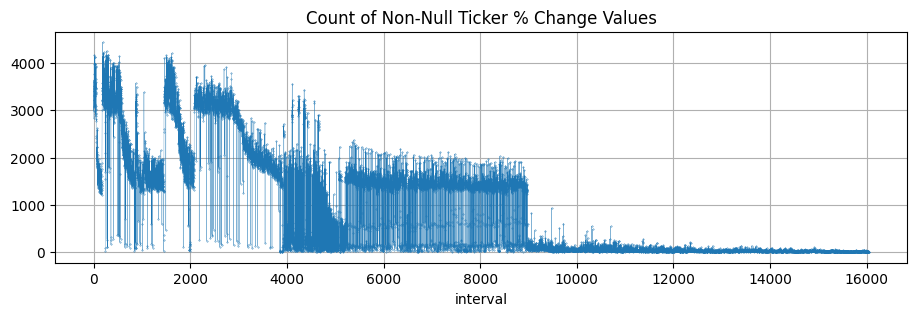

In [201]:
fig, ax = plt.subplots(figsize=(11,3))
ax.plot(x_non_null, lw=0.2, marker='o', markersize=0.3)
ax.set_title('Count of Non-Null Ticker % Change Values')
ax.set_xlabel('interval')
ax.grid(axis='both')
plt.show()

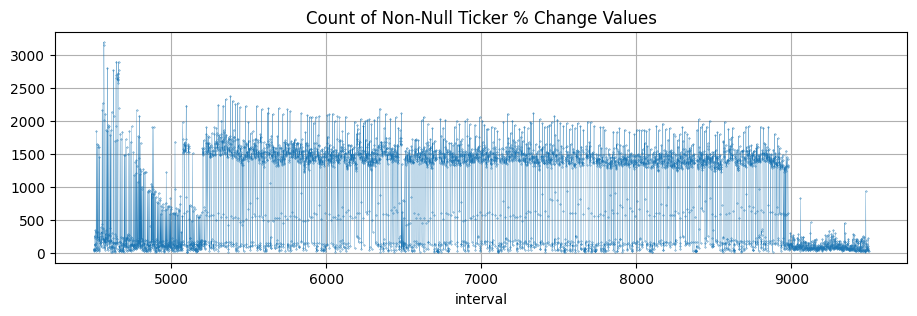

In [221]:
fig, ax = plt.subplots(figsize=(11,3))
ax.plot(range(4500,9500), x_non_null[4500:9500], lw=0.2, marker='o', markersize=0.3)
ax.set_title('Count of Non-Null Ticker % Change Values')
ax.set_xlabel('interval')
ax.grid(axis='both')
plt.show()

# STOPPED HERE 1/20/2025
The data covers far less time than expected.  The sum of valid tickers by letter declines by 25-50% over time for almost all letters.   

### Observation
The count of non-null % change values by tickers over time shows unstable totals that drop from ~2000 to almost 0 just after the halfway point of the historical range. 

### Reduce df date range periods with more than 500 valid % Change values exist


In [218]:
x_non_null_roll_30 = pd.Series(x_non_null).rolling(30).mean()

idx_last_gt_500_non_null = x_non_null_roll_30[
                            x_non_null_roll_30 > 500].index[-1]
idx_last_gt_500_non_null

np.int64(8995)

In [234]:
df = df.iloc[:idx_last_gt_500_non_null]
df.sort_index(inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_13536\1724769964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True)


In [238]:
df.index = pd.to_datetime(df.index, unit='ms')

In [239]:
df.index[0], df.index[-1]

(Timestamp('2022-08-29 08:30:00'), Timestamp('2024-08-27 18:30:00'))

c:\users\user\onedrive\stocks\research & reference\nb\lib\site-packages\pandas\core\arrays\sparse\array.py:1556: RuntimeWarning: invalid value encountered in scalar divide
  return sp_sum / ct


<Axes: xlabel='time'>

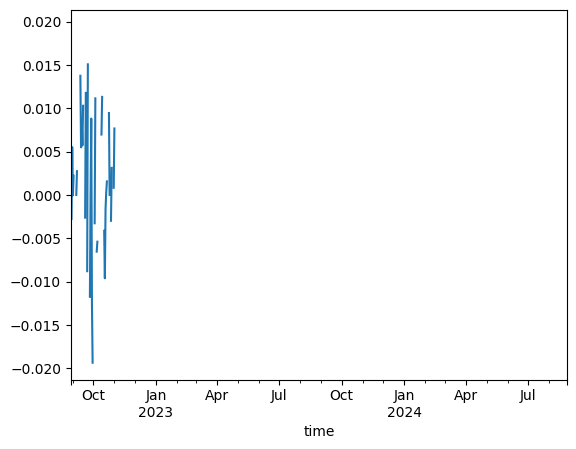

In [244]:
df[tickers_top[4]].resample('D').mean().plot()

In [ ]:
# pd.date_range(freq='30T')

### Drop Historical Range with low Ticker Count 

In [202]:
x_non_null

array([2836, 3468, 3629, ...,    4,    3,    2])

### Identify Tickers in Top 30 Highest Percent Change

In [131]:
n_highest_tickers = 30

In [47]:
test = df.iloc[:10]

In [48]:
%%timeit
test.agg(lambda x: x.nlargest(n_highest_tickers).index.tolist(), axis=1)

1.11 s ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%%timeit
test.apply(lambda x: x.nlargest(n_highest_tickers).index.tolist(), axis=1)

1 s ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
df_tickers = test.apply(lambda x: x.nlargest(n_highest_tickers).index.tolist(), axis=1)
df_tickers

time
1661779800000    [CMRX, GCT, NMTC, UEC, GOTU, BIVI, URG, TAL, N...
1661866200000    [GTII, VRAX, NBEV, INAB, CONN, GSFI, MOHO, PXM...
1662039000000    [PIXY, GCT, HKD, INND, WNW, HPCO, INAB, TONR, ...
1662125400000    [ATYG, PPJE, PIXY, BIAFW, CMCM, NA, ALST, AHI,...
1662127200000    [AHI, APE, TYDE, AGRI, GCT, NOGN, MOHO, PETZ, ...
1662130800000    [AHI, ATYG, NUWE, KPRX, USEA, CMCM, XFOR, BXRX...
1662132600000    [AHI, MIRO, PXMD, SHPH, EYPT, VSTA, NYC, CHRA,...
1662138000000    [FRZA, EDNMY, LQDA, ARDX, CRHC, WHLR, YI, MAPS...
1662143400000    [CRTD, BGXX, RVPH, BNR, MGAM, INDO, GFAI, HPCO...
1662145200000    [DRTS, AABB, SHPH, MOB, KALA, INDO, IMPP, JFBR...
dtype: object

In [67]:
df_top_pct = test.apply(lambda x: x.nlargest(n_highest_tickers).dropna().values, axis=1)
df_top_pct

time
1661779800000    [0.20560747663551404, 0.19587912087912085, 0.1...
1661866200000    [0.34428678117998524, 0.20523415977961434, 0.1...
1662039000000    [0.7901399067288475, 0.4537474679270763, 0.247...
1662125400000    [0.75, 0.5714285714285716, 0.28301698886936144...
1662127200000    [0.6032064128256514, 0.15551907208801508, 0.09...
1662130800000    [0.2086330935251799, 0.10000000000000009, 0.09...
1662132600000    [0.08365584995534392, 0.08000000000000007, 0.0...
1662138000000    [0.04282115869017611, 0.028000000000000025, 0....
1662143400000    [0.11143781240811523, 0.08152508727496754, 0.0...
1662145200000    [0.13873873873873888, 0.08408617095204995, 0.0...
dtype: object

### Create df_tickers 

In [73]:
# sample method of identifying tickers that were top performers
# two bars in a row
list(set(df_tickers.iloc[4]).intersection(set(df_tickers.iloc[5])))

['GRFX', 'NOGN', 'KPRX', 'ATYG', 'AHI']

In [226]:
df_tickers = df.apply(lambda x: x.nlargest(n_highest_tickers).index.tolist(), axis=1)
df_tickers

time
1661779800000    [CMRX, GCT, NMTC, UEC, GOTU, BIVI, URG, TAL, N...
1661866200000    [GTII, VRAX, NBEV, INAB, CONN, GSFI, MOHO, PXM...
1662039000000    [PIXY, GCT, HKD, INND, WNW, HPCO, INAB, TONR, ...
1662125400000    [ATYG, PPJE, PIXY, BIAFW, CMCM, NA, ALST, AHI,...
1662127200000    [AHI, APE, TYDE, AGRI, GCT, NOGN, MOHO, PETZ, ...
                                       ...                        
1661814000000    [GTE, HEI, DRUG, U, CCJ, MARA, UBER, SNAP, PTO...
1661815800000    [JZ, DRUG, IQ, PDD, MARA, TLRY, NERV, COIN, GM...
1661891400000    [NOGN, HPCO, MGAM, INAB, TTOO, AKLI, PSTG, AMR...
1661895000000    [GMBL, MGAM, PEV, SLGG, NOGN, HPCO, AESE, APRN...
1661902200000    [VERU, NOGN, HOUR, PSFE, APE, CPTN, PLUG, LCID...
Length: 8995, dtype: object

In [227]:
df_tickers.shape

(8995,)

In [228]:
df_tickers.head()

time
1661779800000    [CMRX, GCT, NMTC, UEC, GOTU, BIVI, URG, TAL, N...
1661866200000    [GTII, VRAX, NBEV, INAB, CONN, GSFI, MOHO, PXM...
1662039000000    [PIXY, GCT, HKD, INND, WNW, HPCO, INAB, TONR, ...
1662125400000    [ATYG, PPJE, PIXY, BIAFW, CMCM, NA, ALST, AHI,...
1662127200000    [AHI, APE, TYDE, AGRI, GCT, NOGN, MOHO, PETZ, ...
dtype: object

In [229]:
tickers_top = sorted(df_tickers.explode().unique())
len(tickers_top), tickers_top[:5]

(8579, ['A', 'AA', 'AABB', 'AAC', 'AACAY'])

In [230]:
df.loc[:, tickers_top]

,A,AA,AABB,AAC,AACAY,AACG,AACI,AACIU,AACIW,AACT,...,ZURVY,ZVIA,ZVO,ZVRA,ZVSA,ZWS,ZY,ZYME,ZYNE,ZYXI
time,,,,,,,,,,,,,,,,,,,,,
1661779800000,-0.001479,0.011298,0.053105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.040404,NaN,NaN,NaN,0.004582,NaN,NaN,NaN,NaN
1661866200000,0.002334,-0.039534,0.022735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.006256,NaN,NaN,NaN,NaN,-0.009036,NaN,-0.00463,NaN,0.001119
1662039000000,-0.003291,-0.008701,0.024308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000631,NaN,NaN,NaN,NaN,-0.013216,-0.021552,NaN,NaN,-0.016797
1662125400000,-0.008051,0.000203,0.024194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.001208,NaN,NaN,NaN,NaN,-0.013475,-0.041841,-0.030534,NaN,-0.009361
1662127200000,0.002564,0.007098,0.039062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.022972,NaN,NaN,NaN,0.003642,-0.002183,NaN,NaN,-0.004449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661814000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1661815800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1661891400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
import numpy as np

In [99]:
import time

In [231]:
# x_ = df.loc[:, tickers_top].iloc[:5000].values

# for kind_ in ['quicksort', 'mergesort', 'heapsort', 'stable']:
#     t0 = time.time()
    
#     np.sort(x_, axis=1, kind=kind_)
#     t1 = time.time()
#     print(kind_, t1-t0)

In [170]:
# select top n_highest_tickers pct change per bar
# reduce dataset by subsetting to only tickers_top
# x_ = df.loc[:, tickers_top].values
pct_change_top = np.round(-np.sort(-df.loc[:, tickers_top].values, axis=1, 
                 kind='quicksort')[:, :n_highest_tickers], 4)
pct_change_top[0]

array([0.2056, 0.1959, 0.1628, 0.1503, 0.1197, 0.107 , 0.1033, 0.1017,
       0.0993, 0.0973, 0.0956, 0.0947, 0.0936, 0.0903, 0.09  , 0.0899,
       0.0883, 0.0882, 0.0871, 0.0861, 0.0847, 0.0836, 0.0807, 0.0806,
       0.077 , 0.0748, 0.0718, 0.0679, 0.0672, 0.0669])

### EDA
Copied from notebook 1.

<Axes: >

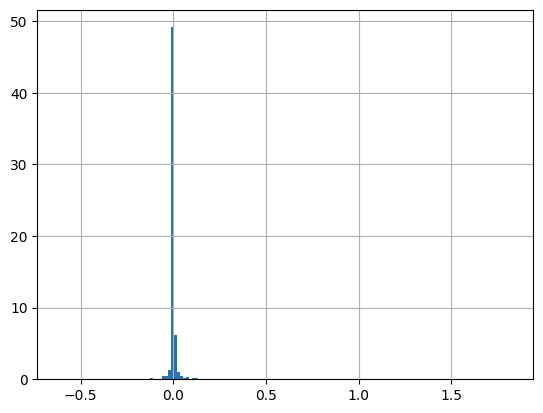

In [25]:
df_sparse.mean().hist(bins=150, density=True)

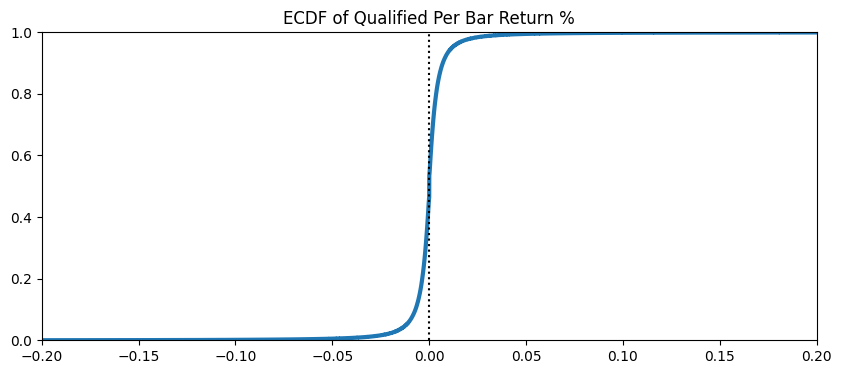

In [26]:
fig, ax = plt.subplots(figsize = (10,4))
ax.ecdf(df_sparse.stack().dropna().values, lw=3)
ax.set_xlim(-0.2, 0.2)
ax.axvline(0, color='black', linestyle=':')
ax.set_title('ECDF of Qualified Per Bar Return %')
plt.show()

### Review Quality Checks

In [27]:
df_checks = pd.DataFrame.from_dict(quality_checks, orient='index',
                                   columns=cols_checks)
# save df_checks to disk
file_checks = dir_data / 'quality_checks.csv'
df_checks.to_csv(file_checks)
assert file_checks.is_file()
print(file_checks)
df_checks.head()

C:\Users\user\OneDrive\STOCKS\Research & Reference\nb\max possible return on equity\src\data\quality_checks.csv


,has_required_cols,has_min_volume,has_qualified_records
AAALY,True,0.000000,False
AABB,True,0.027597,True
AABVF,True,0.000000,False
AACAF,True,0.000000,False
AACAY,True,0.026025,True


In [28]:
df_checks.mean()

has_required_cols        1.000000
has_min_volume           0.161288
has_qualified_records    0.562547
dtype: float64

#### How many Tickers have at least one qualified bar (interval)?

In [29]:
df_checks['has_qualified_records'].value_counts().to_frame(
    name='Count of Qualified Tickers')

,Count of Qualified Tickers
has_qualified_records,
True,12088
False,9400


#### How many Tickers meet Minimum Trading \\$ Volume Criteria?
..across available intervals

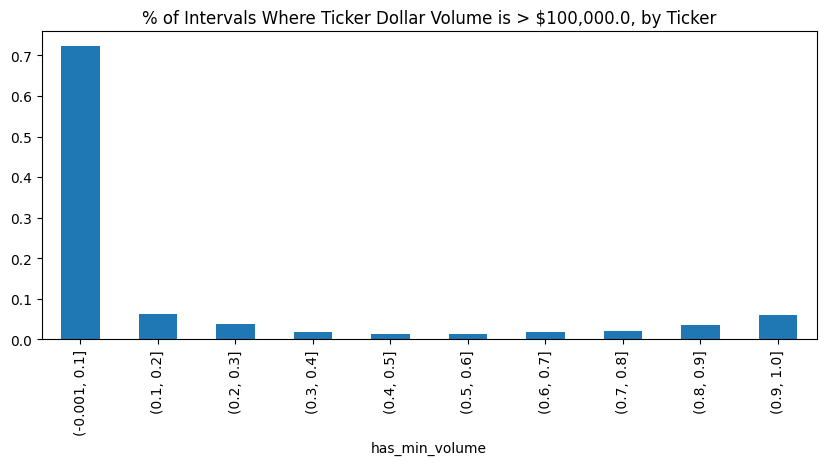

In [30]:
pd.cut(df_checks['has_min_volume'], bins=10).value_counts(normalize=True)\
    .sort_index().plot.bar(figsize=(10,4), 
       title=f'% of Intervals Where Ticker Dollar Volume is > ${parameters["min_ticker_dollar_volume"]:,}, by Ticker')
plt.show()